# Introduction

In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import numpy as np
import scipy.io.wavfile
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib

In [ ]:
# Path variables
drive_path  = "/content/drive/My Drive/KInsekten/"
data_path   = drive_path + "data/Keogh/"

# Import wingbeats package
os.chdir(drive_path)
import wingbeats
from wingbeats.modelling import *
from wingbeats.processing import *
from wingbeats.xai import *

# Plot font sizes
title_size = 32
label_size = ticks_size = title_size - 5
fig_size   = (20, 21)

In [ ]:
strategy = 'GPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

In [ ]:
!git clone https://github.com/scikit-learn-contrib/imbalanced-learn.git
from imblearn.over_sampling._smote import SMOTE

Cloning into 'imbalanced-learn'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 8606 (delta 34), reused 23 (delta 8), pack-reused 8513
Receiving objects: 100% (8606/8606), 21.31 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (5908/5908), done.


# Load signals

Species and Genus encoding

In [ ]:
# Dictionary of genera with the included species
genus_species_dict = {
    'Beetles': ['beetles'],
    'Bees': ['honeybees'],
    'Flies': ['house_flies', 'fruit_flies', 'moth_flies'],
    'Mosquitoes': ['aedes', 'anopheles', 'quinx', 'tarsalis']
}

transfer_learning = False # first train on 7 species, then do transfer learning on all 9
if not transfer_learning:
  genus_species_dict['Flies'].remove('moth_flies')
  genus_species_dict['Mosquitoes'].remove('anopheles')

# Store species from the dictionary values (list flattening)
species = [s for l in list(genus_species_dict.values()) for s in l]
print(species)

# Store genus from the keys
genus = list(genus_species_dict.keys())
print(genus)

# Store genus that each species belongs to as a Look-Up Table
genus_mapping = []
for val, gen_ind in zip(genus_species_dict.values(), range(len(genus))):
  genus_mapping += [gen_ind] * len(val)
print(genus_mapping)

['beetles', 'honeybees', 'house_flies', 'fruit_flies', 'aedes', 'quinx', 'tarsalis']
['Beetles', 'Bees', 'Flies', 'Mosquitoes']
[0, 1, 2, 2, 3, 3, 3]


Class Embeddings

In [ ]:
# Similarity matrix
S = np.identity(len(species))

diag_ind = 0
for gen_ind in range(len(genus)):

  # How many species belong to the current genus index?
  spec_in_gen = genus_mapping.count(gen_ind)
  
  # Each sub-block corresponding to a genus will be filled with 1/2
  # except along the diagonal which has 1's
  for i in range(spec_in_gen):
    for j in range(spec_in_gen):
      if i != j:
        S[diag_ind+i, diag_ind+j] = 1/2

  diag_ind += spec_in_gen
print(S)

[[1.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.  0.  0. ]
 [0.  0.  0.5 1.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.5 0.5]
 [0.  0.  0.  0.  0.5 1.  0.5]
 [0.  0.  0.  0.  0.5 0.5 1. ]]


In [ ]:
# Compute matrix of embedded vectors from similarity matrix
emb_matrix = np.asarray( unitsphere_embedding(S), dtype = np.float32 )
genus_mapping = np.asarray(genus_mapping)
print(emb_matrix)

[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.8660254  0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.5        0.8660254
  0.        ]
 [0.         0.         0.         0.         0.5        0.28867513
  0.8164966 ]]


Construct data matrix X_train

In [ ]:
X_train, y_train = [], []
sampling_rate = 16000

load_signals(data_path, species, X_train, y_train, genus_mapping, with_scipy = False)

beetles: 172
honeybees: 511
house_flies: 1343
fruit_flies: 777
aedes: 4756
quinx: 3137
tarsalis: 5309

Total: 16005


[172, 511, 1343, 777, 4756, 3137, 5309]

In [ ]:
# Normalize amplitudes and map them to [-1, 1]
for i in range(len(X_train)):
  X_train[i] = X_train[i] / np.max(np.abs(X_train[i])) #np.iinfo(np.int16).max 

# Data cleaning

**Cropping**

In [ ]:
# Shorten training and test sets
len_sig = 1680
cut_off_rms(X_train, min_len = len_sig, nperseg = len_sig//2, hop_len = len_sig//16)

**Outliers**

In [ ]:
# Store outliers from histograms (see Keogh_Experiments.ipynb)
freq_resol = sampling_rate / len_sig # frequency resolution
cutoff_1, cutoff_2 = 100, 1000 #Hz
cutoff_1, cutoff_2 = int(np.ceil(cutoff_1 / freq_resol)), int(np.ceil(cutoff_2 / freq_resol)) # cutoff index in amp. spectrum
outliers = {}
outlier_ind = []
if len(species) == 9:
  thresholds = [12.11, 12.12, 10.67, 10.31, 20.58, 7.75, 5.47, 9.56, 6.90]
elif len(species) == 7:
  thresholds = [12.11, 12.12, 10.67, 10.31,        7.75,       9.56, 6.90] # no moths and anopheles

for ind in range(len(species)):
  
  # Get signal indexes corresponding to current species
  spec_ind = np.where(np.asarray(y_train)[:,1] == ind) 
  outliers[species[ind]] = []

  for sig_ind in spec_ind[0]: 
    four = np.fft.fft(X_train[sig_ind])

    # Label as outlier if max. amplitude is less than threshold and 15
    if max(np.abs(four[cutoff_1:cutoff_2])) < min(thresholds[ind], 15.0):
      outliers[species[ind]].append(X_train[sig_ind])
      outlier_ind.append(sig_ind)
      
print(str(len(outlier_ind)) + ' outliers')

28 outliers


In [ ]:
# Remove outliers from data matrix
outliers_removed = 0
for out_ind in outlier_ind:
  del X_train[out_ind - outliers_removed]
  del y_train[out_ind - outliers_removed]
  outliers_removed += 1
len(X_train)

15977

# Data preprocessing

In [ ]:
# Define initial training parameters
epochs = 30 # should be large enough for EarlyStopping to be beneficial
batch_size = 64
drop_rate = 0.5  # set to 0.0 when training frozen models
n_splits = 4 # number of folds in cross-val.
in_shape = (129, 33, 3)

In [ ]:
# Define input format
input_format = 'spectro'

# Define model type according to the structure of the outputs
model_names = ['SimpleCls', 'Emb', 'SimpleEmbCls', 'HieraCls', 'HieraEmbCls']

# Parameters for Welch-Transform
window   = tf.signal.hann_window    # window function ('hanning' is a squared cosine filter)
nperseg  = 2*256        # length of each segment 
# Note: hop_len needs to be chosen such that the time axis in spectrograms has at least 32 points
hop_len  = int( nperseg // np.round( 31 * nperseg / (len_sig - nperseg) ) )
noverlap = nperseg - hop_len   
cutoff   = 129          # how many frequencies to keep after Welch (if None, keep them all)

In [ ]:
# Split whole set into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, 
                                                    random_state = 2020, shuffle = True, stratify = y_train)
# Note: Don't modify random_seed! It ensures that the same split is carried out in every experiment,
#       which is important for the comparability of the results.

# Train models 

Note: Hyperband-Tuning will be done only with EarlyStopper, no learning schedule

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Stop training when val_loss is no longer improving
earlyStopper = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-3,
    patience = 5, 
    verbose = 1)

In [ ]:
# Define SMOTE amounts for underrepresented species
smote_dict = {} 
for i in [0, 1]:
    len_train = len(np.where(np.asarray(y_train)[:,1] == i)[0]) * (n_splits-1)//n_splits # only the train set should be augmented
    smote_dict[i] = len_train * 2 # each problematic species is augmented 2 times   
# Construct SMOTE object
sm = SMOTE(sampling_strategy = smote_dict, random_state = 2020)
print(smote_dict)

{0: 204, 1: 610}


## Simple Classifier

In [ ]:
model_name = model_names[0] + '_' + input_format 
print(model_name)
out_shape = len(species)
lr, reg = 5e-4, 1e-3

lr_sched = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    min_delta = 1e-2,
    min_lr = lr * 0.01, 
    patience = 3, 
    verbose = 1)

model_callbacks = [earlyStopper, lr_sched]

SimpleCls_spectro


In [ ]:
# One model for each split in KFold
models = []
for i in range(n_splits):
    tf.keras.backend.clear_session() # avoid stacking graphs on one another
    with strategy.scope():
        cnn = CNN2D(drop_rate, name = 'CNN_Blocks'+str(i)) 
        model = build_simple_classifier(in_shape, out_shape, cnn, reg, 
                                        input_name = input_format, model_name = model_name)
        model.compile(tf.keras.optimizers.Adam(lr), 'sparse_categorical_crossentropy', ['accuracy'])
    models.append(model)

In [ ]:
gen_mean, gen_std, spec_mean, spec_std, histories = kfold_cv(X_train, y_train, models, genus_mapping, emb_matrix, 
                                                             n_splits, epochs, batch_size, sm, model_callbacks, 
                                                             sampling_rate, window, nperseg, noverlap, cutoff)


FOLD 1

Epoch 00007: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 5e-06.
Epoch 00019: early stopping

FOLD 2

Epoch 00009: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
Epoch 00017: early stopping

FOLD 3

Epoch 00010: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
Epoch 00018: early stopping

FOLD 4

Epoch 00007: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 5e-06.
Epoch 00014: early stopping
*********************************************
MEAN GENUS   VAL_ACC: 0.9614

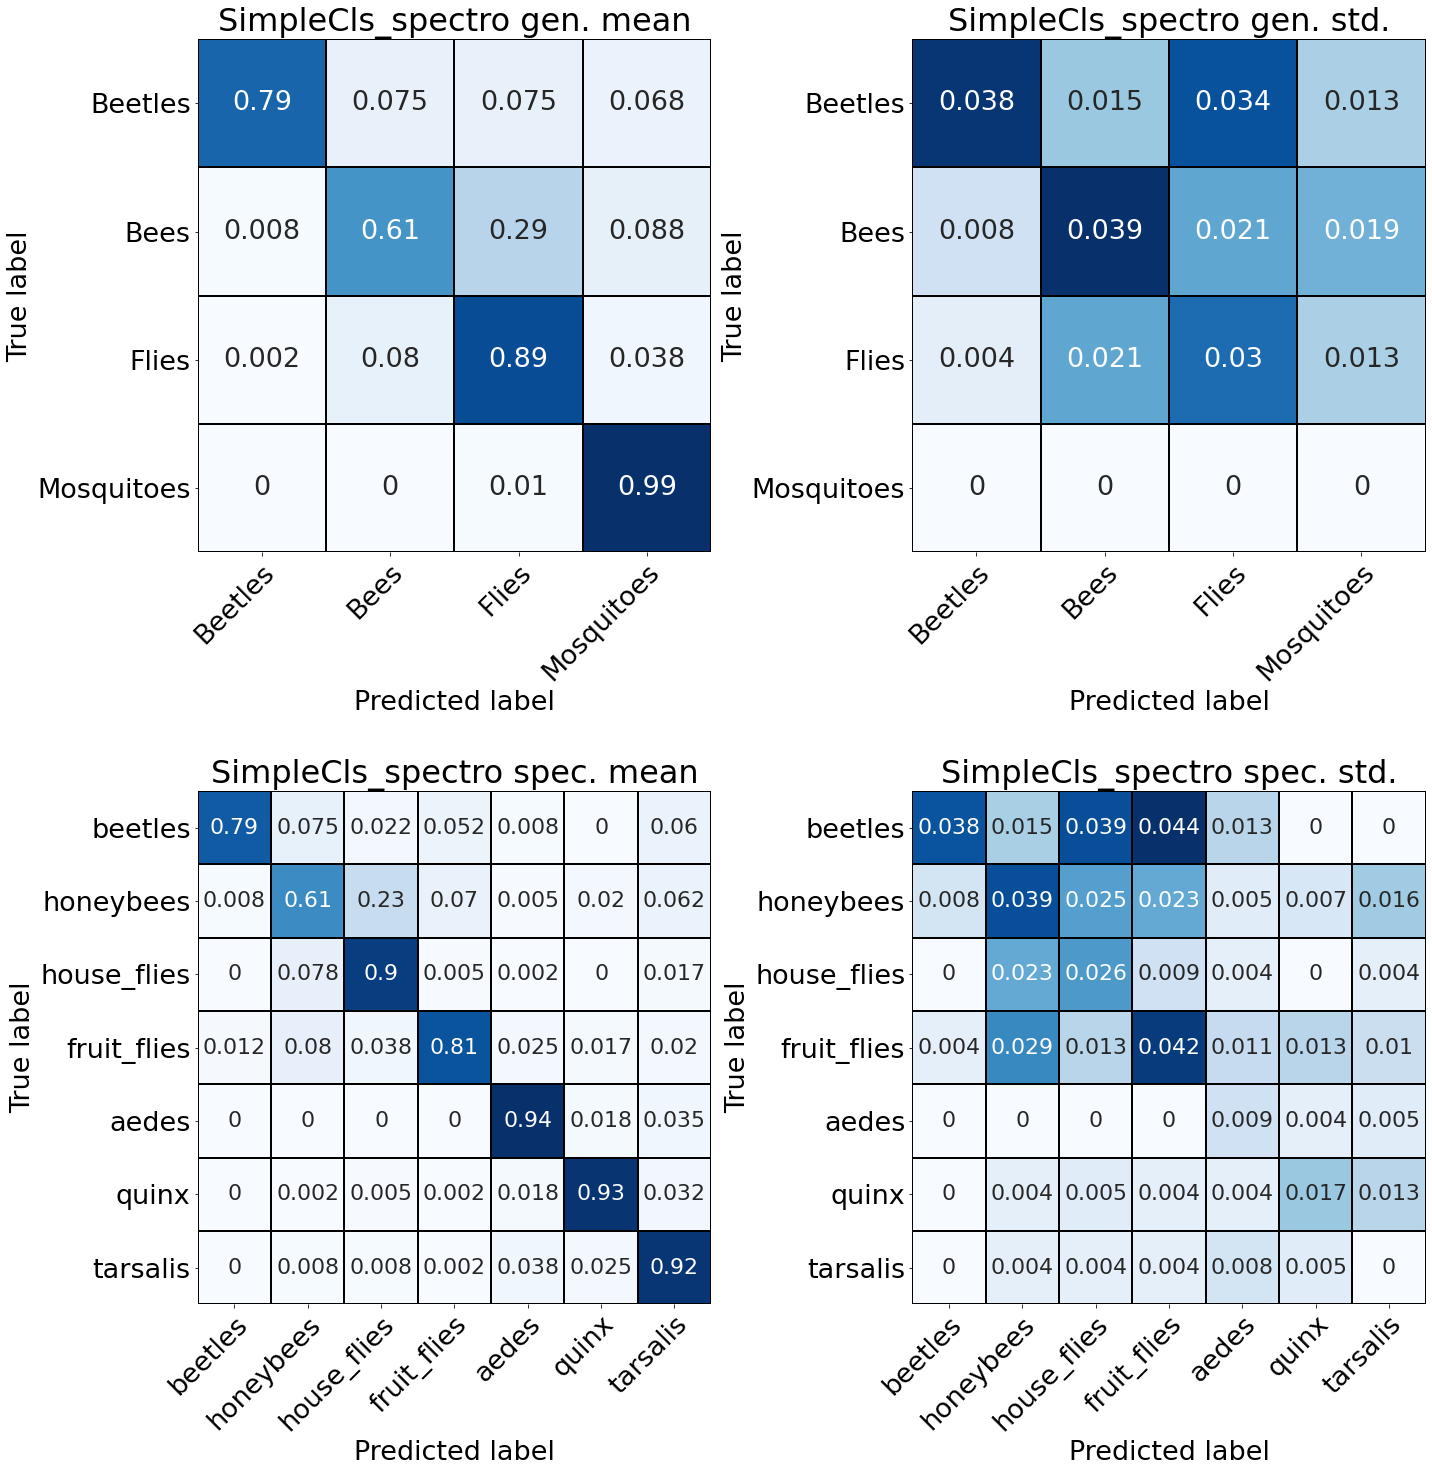

In [ ]:
# Convert confusion matrices into +/- format
#gen_mat, spec_mat = unumpy.uarray(gen_mean, gen_std), unumpy.uarray(spec_mean, spec_std)

fig = plt.figure(figsize = fig_size)
plt.subplot(221)
plot_heatmap(gen_mean, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(222)
plot_heatmap(gen_std, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(223)
plot_heatmap(spec_mean, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)

plt.subplot(224)
plot_heatmap(spec_std, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)
plt.tight_layout()
fig.savefig(model_name + '_kconf.eps', bbox_inches = 'tight')
plt.show()

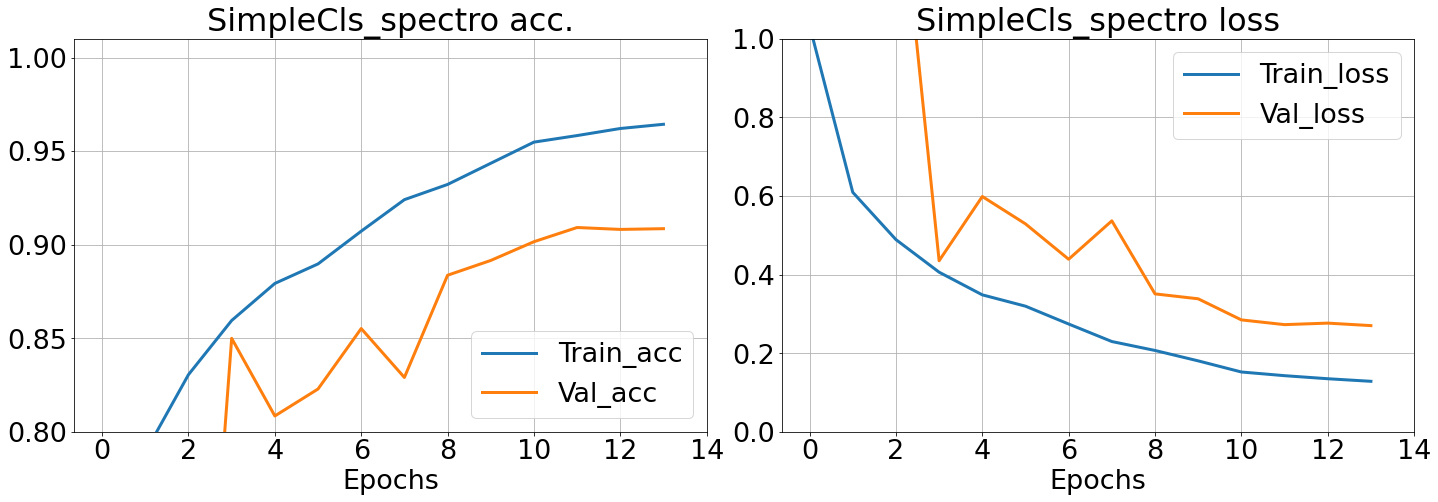

In [ ]:
# Compute mean statistics up to earliest training stop
stop_ep = 14
mean_train_acc  = np.zeros((stop_ep, ))
mean_val_acc    = np.zeros((stop_ep, ))
mean_train_loss = np.zeros((stop_ep, ))
mean_val_loss   = np.zeros((stop_ep, ))
for i in range(n_splits):
    mean_train_acc  += histories[i]['accuracy'][:stop_ep]
    mean_val_acc    += histories[i]['val_accuracy'][:stop_ep]
    mean_train_loss += histories[i]['loss'][:stop_ep]
    mean_val_loss   += histories[i]['val_loss'][:stop_ep]

mean_train_acc  /= n_splits
mean_val_acc    /= n_splits
mean_train_loss /= n_splits
mean_val_loss   /= n_splits

fig = plt.figure(figsize = (20, 7))

plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, linewidth = 3)
plt.plot(mean_val_acc, linewidth = 3)
plt.ylim(0.8, 1.01)
plt.xticks(np.linspace(0, stop_ep, 8), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + ' acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, linewidth = 3)
plt.plot(mean_val_loss, linewidth = 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.linspace(0, stop_ep, 8), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(fontsize = ticks_size)
plt.title(model_name + ' loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_kacc.eps', bbox_inches = 'tight')
plt.show()

## Embedder

In [ ]:
model_name = model_names[1] + '_' + input_format 
print(model_name)
out_shape = len(species)
lr, reg = 1e-3, 1e-4

lr_sched = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    min_delta = 1e-2,
    min_lr = lr * 0.01, 
    patience = 3, 
    verbose = 1)

model_callbacks = [earlyStopper, lr_sched]

Emb_spectro


In [ ]:
# One model for each split in KFold
models = []
for i in range(n_splits):
    tf.keras.backend.clear_session() # avoid stacking graphs on one another
    with strategy.scope():
        cnn = CNN2D(drop_rate, name = 'CNN_Blocks'+str(i)) 
        model = build_embedder(in_shape, out_shape, cnn, reg, input_format, model_name)
        model.compile(tf.keras.optimizers.Adam(lr), 
                      loss = embedding_loss(emb_matrix),
                      metrics = embedding_similarity(emb_matrix))
    models.append(model)

In [ ]:
gen_mean, gen_std, spec_mean, spec_std, histories = kfold_cv(X_train, y_train, models, genus_mapping, emb_matrix, 
                                                             n_splits, epochs, batch_size, sm, model_callbacks, 
                                                             sampling_rate, window, nperseg, noverlap, cutoff)


FOLD 1

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00016: early stopping

FOLD 2

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00019: early stopping

FOLD 3

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00019: early stopping

FOLD 4

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau r

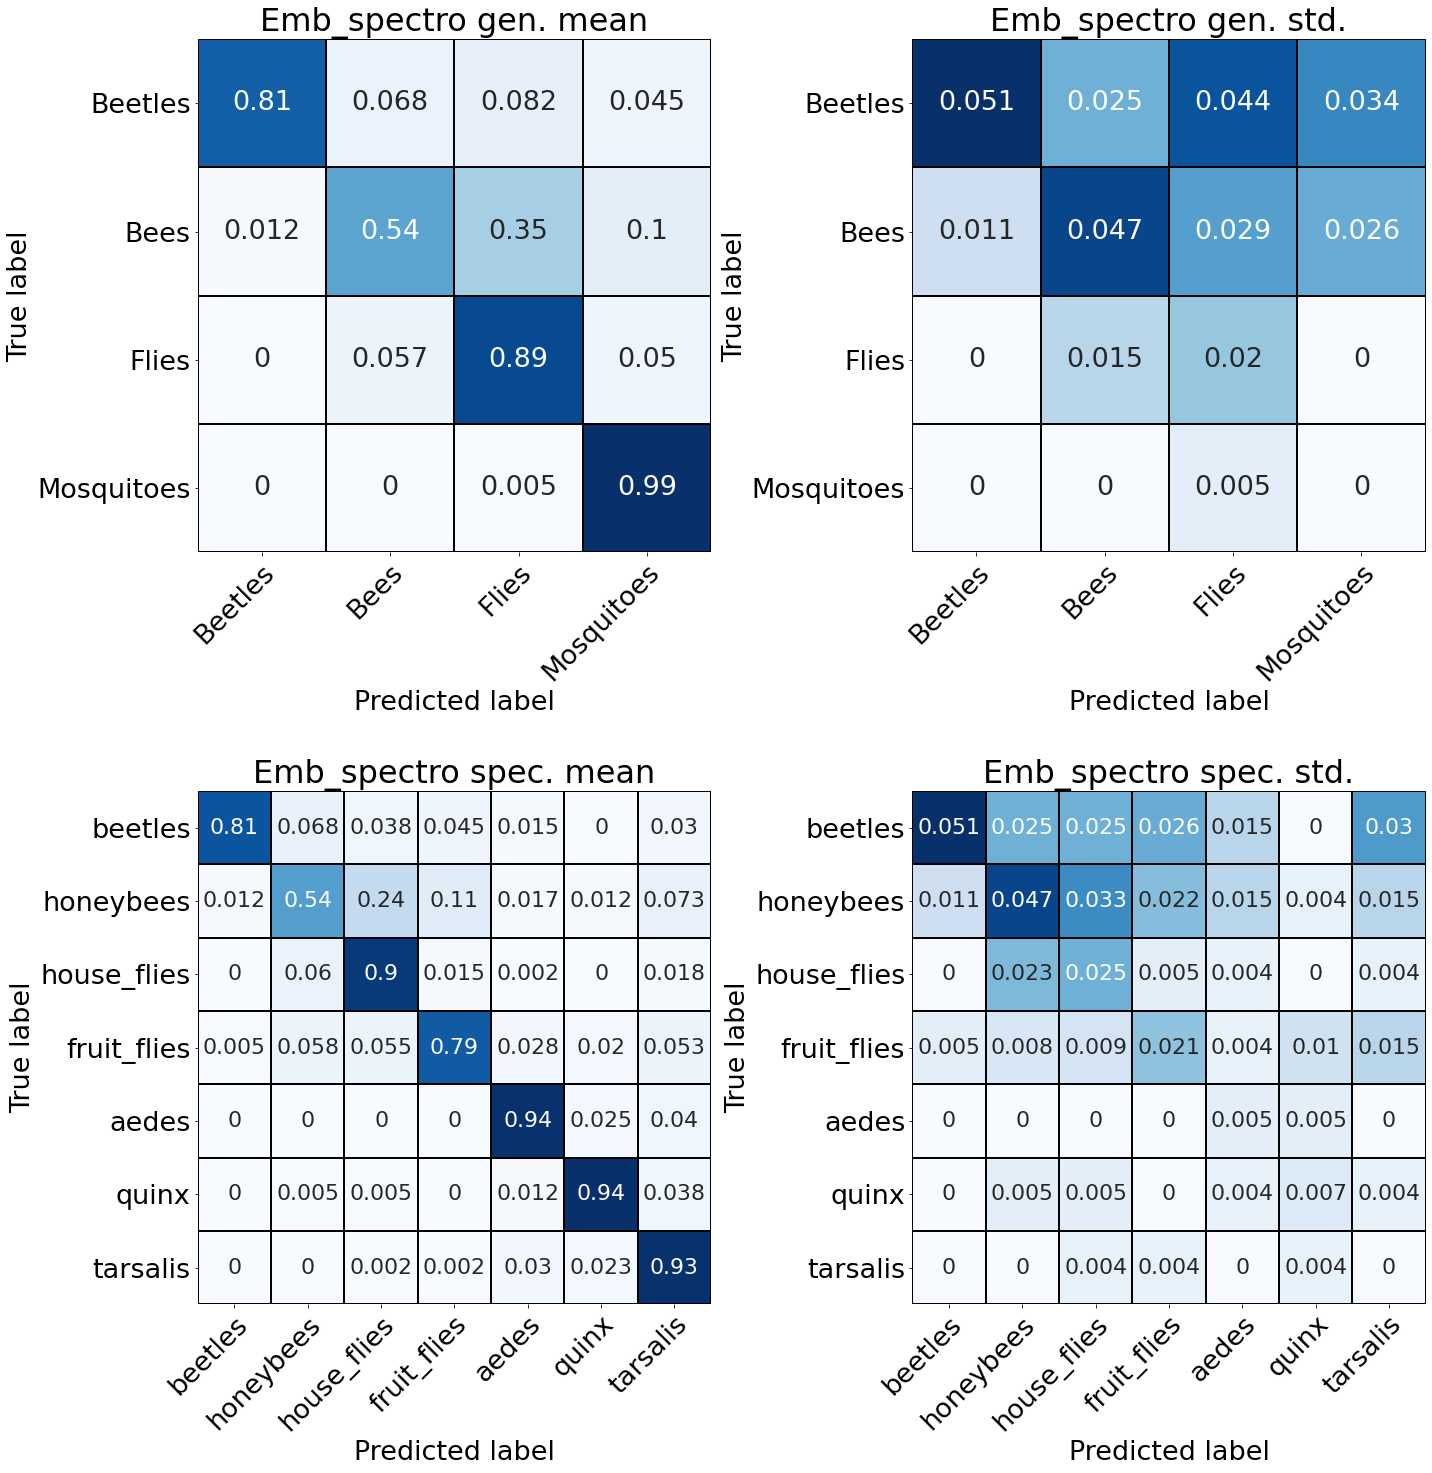

In [ ]:
# Convert confusion matrices into +/- format
#gen_mat, spec_mat = unumpy.uarray(gen_mean, gen_std), unumpy.uarray(spec_mean, spec_std)

fig = plt.figure(figsize = fig_size)
plt.subplot(221)
plot_heatmap(gen_mean, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(222)
plot_heatmap(gen_std, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(223)
plot_heatmap(spec_mean, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)

plt.subplot(224)
plot_heatmap(spec_std, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)
plt.tight_layout()
fig.savefig(model_name + '_kconf.eps', bbox_inches = 'tight')
plt.show()

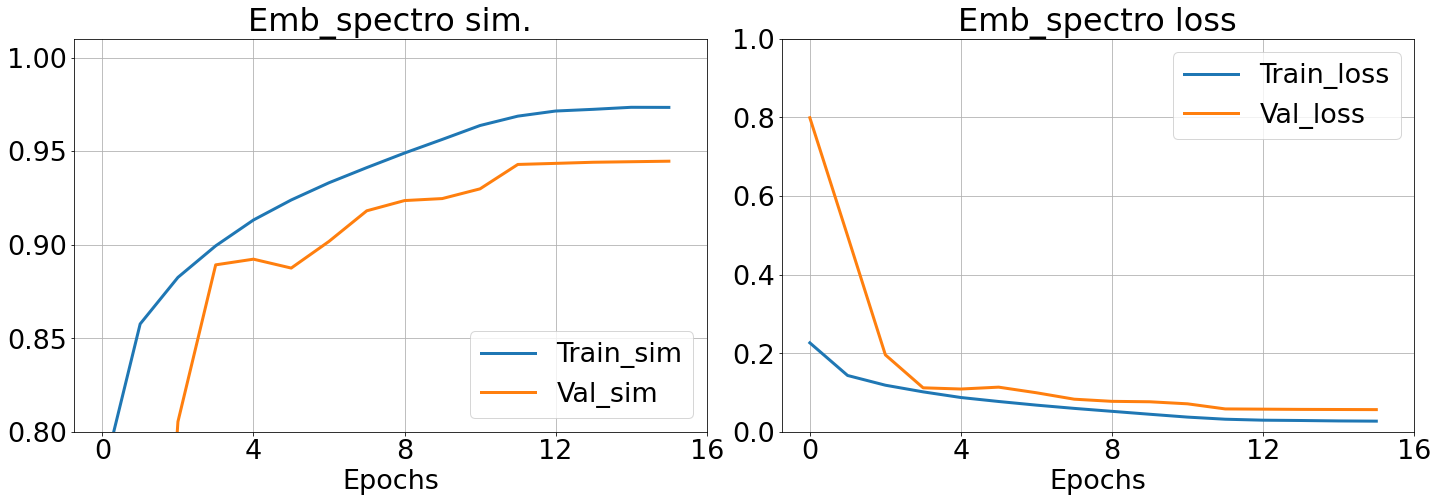

In [ ]:
# Compute mean statistics up to earliest training stop
stop_ep = 16
mean_train_acc  = np.zeros((stop_ep, ))
mean_val_acc    = np.zeros((stop_ep, ))
mean_train_loss = np.zeros((stop_ep, ))
mean_val_loss   = np.zeros((stop_ep, ))
for i in range(n_splits):
    mean_train_acc  += histories[i]['similarity'][:stop_ep]
    mean_val_acc    += histories[i]['val_similarity'][:stop_ep]
    mean_train_loss += histories[i]['loss'][:stop_ep]
    mean_val_loss   += histories[i]['val_loss'][:stop_ep]

mean_train_acc  /= n_splits
mean_val_acc    /= n_splits
mean_train_loss /= n_splits
mean_val_loss   /= n_splits

fig = plt.figure(figsize = (20, 7))

plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, linewidth = 3)
plt.plot(mean_val_acc, linewidth = 3)
plt.ylim(0.8, 1.01)
plt.xticks(np.linspace(0, stop_ep, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + ' sim.', fontsize = title_size)
plt.legend(['Train_sim', 'Val_sim'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, linewidth = 3)
plt.plot(mean_val_loss, linewidth = 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.linspace(0, stop_ep, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(fontsize = ticks_size)
plt.title(model_name + ' loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_kacc.eps', bbox_inches = 'tight')
plt.show()

## Simple Embedder Classifier

In [ ]:
model_name = model_names[2] + '_' + input_format 
print(model_name)
out_shape = [len(species), len(species)]
lr, reg = 5e-3, 5e-3

lr_sched = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    min_delta = 1e-2,
    min_lr = lr * 0.01, 
    patience = 3, 
    verbose = 1)

model_callbacks = [earlyStopper, lr_sched]

SimpleEmbCls_spectro


In [ ]:
# One model for each split in KFold
models = []
for i in range(n_splits):
    tf.keras.backend.clear_session() # avoid stacking graphs on one another
    with strategy.scope():
        cnn = CNN2D(drop_rate, name = 'CNN_Blocks'+str(i)) 
        model = build_simple_embedder_classifier(in_shape, out_shape, cnn, reg, 
                                                 input_name = input_format, model_name = model_name)
        model.compile(tf.keras.optimizers.Adam(lr), 
                      loss = {
                          "embedding": embedding_loss(emb_matrix), 
                          "species": 'sparse_categorical_crossentropy'
                      },
                      loss_weights = {"embedding": 1.0, "species": 1.0},
                      metrics = {"embedding": embedding_similarity(emb_matrix), "species": 'accuracy'})
    models.append(model)

In [ ]:
gen_mean, gen_std, spec_mean, spec_std, histories = kfold_cv(X_train, y_train, models, genus_mapping, emb_matrix, 
                                                             n_splits, epochs, batch_size, sm, model_callbacks, 
                                                             sampling_rate, window, nperseg, noverlap, cutoff)


FOLD 1

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00019: early stopping

FOLD 2

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00021: early stopping

FOLD 3

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00023: early stopping

FOLD 4

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00021: early stopping
*********************************************
MEAN GENUS   VAL_ACC: 0.9602 +/- 0.0053
MEAN SPECIES VAL_ACC: 0.915 +/- 0.0086


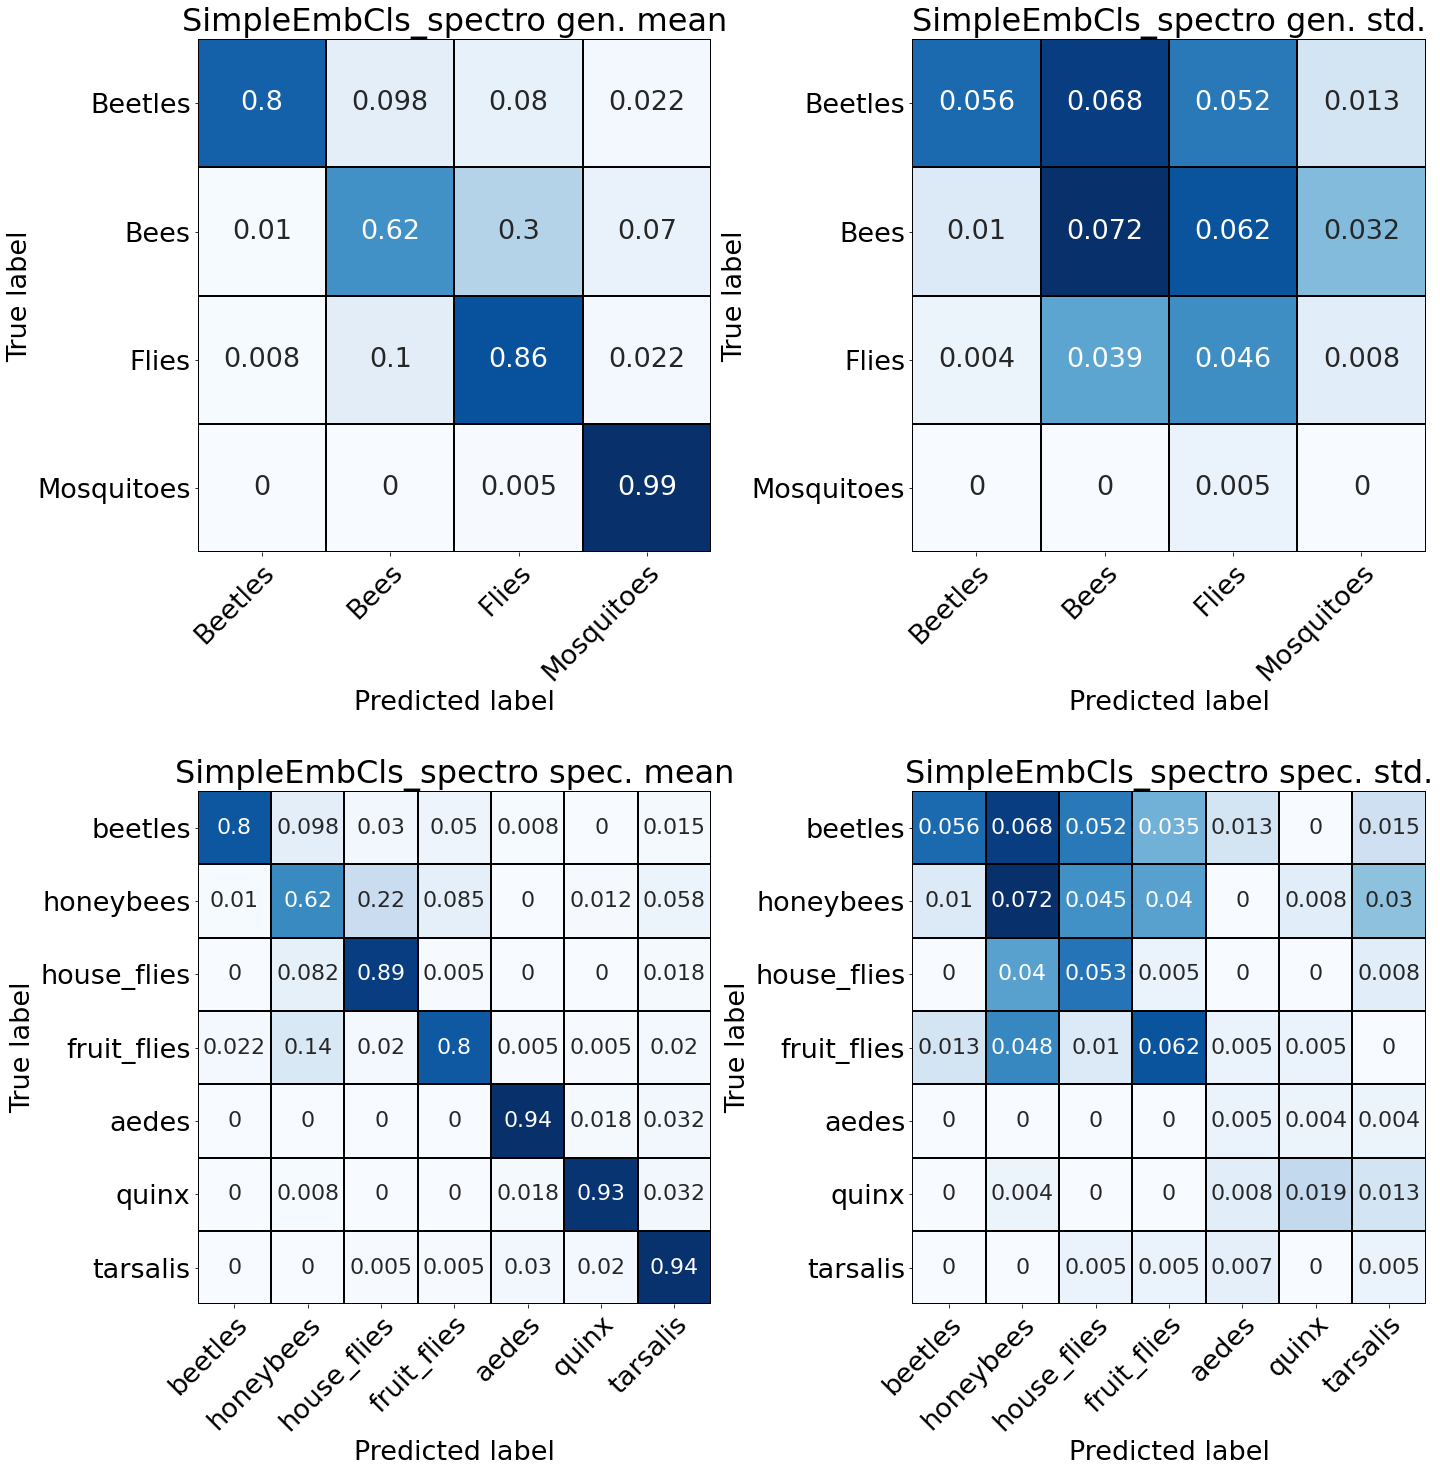

In [ ]:
# Convert confusion matrices into +/- format
#gen_mat, spec_mat = unumpy.uarray(gen_mean, gen_std), unumpy.uarray(spec_mean, spec_std)

fig = plt.figure(figsize = fig_size)
plt.subplot(221)
plot_heatmap(gen_mean, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(222)
plot_heatmap(gen_std, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(223)
plot_heatmap(spec_mean, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)

plt.subplot(224)
plot_heatmap(spec_std, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)
plt.tight_layout()
fig.savefig(model_name + '_kconf.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Compute mean statistics up to earliest training stop
stop_ep = 19
mean_loss          = np.zeros((stop_ep, ))
mean_emb_loss      = np.zeros((stop_ep, ))
mean_spec_loss     = np.zeros((stop_ep, ))
mean_emb_sim       = np.zeros((stop_ep, ))
mean_spec_acc      = np.zeros((stop_ep, ))
mean_val_loss      = np.zeros((stop_ep, ))
mean_val_emb_loss  = np.zeros((stop_ep, ))
mean_val_spec_loss = np.zeros((stop_ep, ))
mean_val_emb_sim   = np.zeros((stop_ep, ))
mean_val_spec_acc  = np.zeros((stop_ep, ))

for i in range(n_splits):
    mean_loss      += histories[i]['loss'][:stop_ep]
    mean_emb_loss  += histories[i]['embedding_loss'][:stop_ep]
    mean_spec_loss += histories[i]['species_loss'][:stop_ep]
    mean_emb_sim   += histories[i]['embedding_similarity'][:stop_ep]
    mean_spec_acc  += histories[i]['species_accuracy'][:stop_ep]
    
    mean_val_loss      += histories[i]['val_loss'][:stop_ep]
    mean_val_emb_loss  += histories[i]['val_embedding_loss'][:stop_ep]
    mean_val_spec_loss += histories[i]['val_species_loss'][:stop_ep]
    mean_val_emb_sim   += histories[i]['val_embedding_similarity'][:stop_ep]
    mean_val_spec_acc  += histories[i]['val_species_accuracy'][:stop_ep]
    
mean_loss      /= n_splits
mean_emb_loss  /= n_splits
mean_spec_loss /= n_splits
mean_emb_sim   /= n_splits
mean_spec_acc  /= n_splits

mean_val_loss      /= n_splits
mean_val_emb_loss  /= n_splits
mean_val_spec_loss /= n_splits
mean_val_emb_sim   /= n_splits
mean_val_spec_acc  /= n_splits

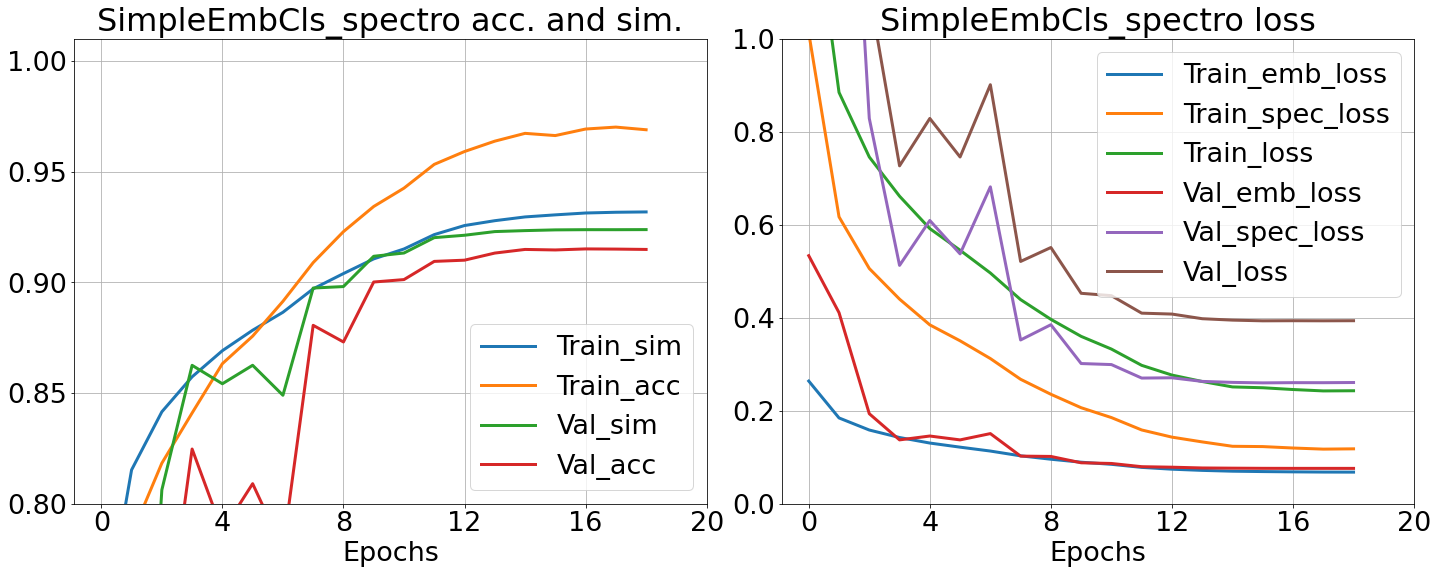

In [ ]:
fig = plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(mean_emb_sim, linewidth = 3)
plt.plot(mean_spec_acc, linewidth = 3)
plt.plot(mean_val_emb_sim, linewidth = 3)
plt.plot(mean_val_spec_acc, linewidth = 3)
plt.ylim(0.8, 1.01)
plt.xticks(np.linspace(0, stop_ep+1, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + ' acc. and sim.', fontsize = title_size)
plt.legend(['Train_sim', 'Train_acc', 'Val_sim', 'Val_acc'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(mean_emb_loss, linewidth = 3)
plt.plot(mean_spec_loss, linewidth = 3)
plt.plot(mean_loss, linewidth = 3)
plt.plot(mean_val_emb_loss, linewidth = 3)
plt.plot(mean_val_spec_loss, linewidth = 3)
plt.plot(mean_val_loss, linewidth = 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.linspace(0, stop_ep+1, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(fontsize = ticks_size)
plt.title(model_name + ' loss', fontsize = title_size)
plt.legend(['Train_emb_loss', 'Train_spec_loss', 'Train_loss', 'Val_emb_loss', 'Val_spec_loss', 'Val_loss'], 
           fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_kacc.eps', bbox_inches = 'tight')
plt.show()

## Hierarchical Classifier

In [ ]:
model_name = model_names[3] + '_' + input_format 
print(model_name)
out_shape = [len(genus), len(species)]
lr, reg = 5e-3, 5e-4

lr_sched = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    min_delta = 1e-2,
    min_lr = lr * 0.01, 
    patience = 3, 
    verbose = 1)

model_callbacks = [earlyStopper, lr_sched]

HieraCls_spectro


In [ ]:
# One model for each split in KFold
models = []
for i in range(n_splits):
    tf.keras.backend.clear_session() # avoid stacking graphs on one another
    with strategy.scope():
        cnn = CNN2D(drop_rate, name = 'CNN_Blocks'+str(i)) 
        model = build_hiera_classifier(in_shape, out_shape, cnn, reg, 
                                       input_name = input_format, model_name = model_name)
        model.compile(tf.keras.optimizers.Adam(lr), 
                      loss = {
                          "genus":   'sparse_categorical_crossentropy', 
                          "species": 'sparse_categorical_crossentropy',
                      },
                      loss_weights = {"genus": 1.0, "species": 1.0},
                      metrics = {"genus": 'accuracy', "species": 'accuracy'})
    models.append(model)

In [ ]:
gen_mean, gen_std, spec_mean, spec_std, histories = kfold_cv(X_train, y_train, models, genus_mapping, emb_matrix, 
                                                             n_splits, epochs, batch_size, sm, model_callbacks, 
                                                             sampling_rate, window, nperseg, noverlap, cutoff)


FOLD 1

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00017: early stopping

FOLD 2

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00015: early stopping

FOLD 3

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00014: early stopping

FOLD 4

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 5e-05.
Epoch 00014: early stopping
*********************************************
MEAN GENUS   VAL_ACC: 0.9663 +/- 0.003
MEAN SPECIES VAL_ACC: 0.9205 +/- 0.0011


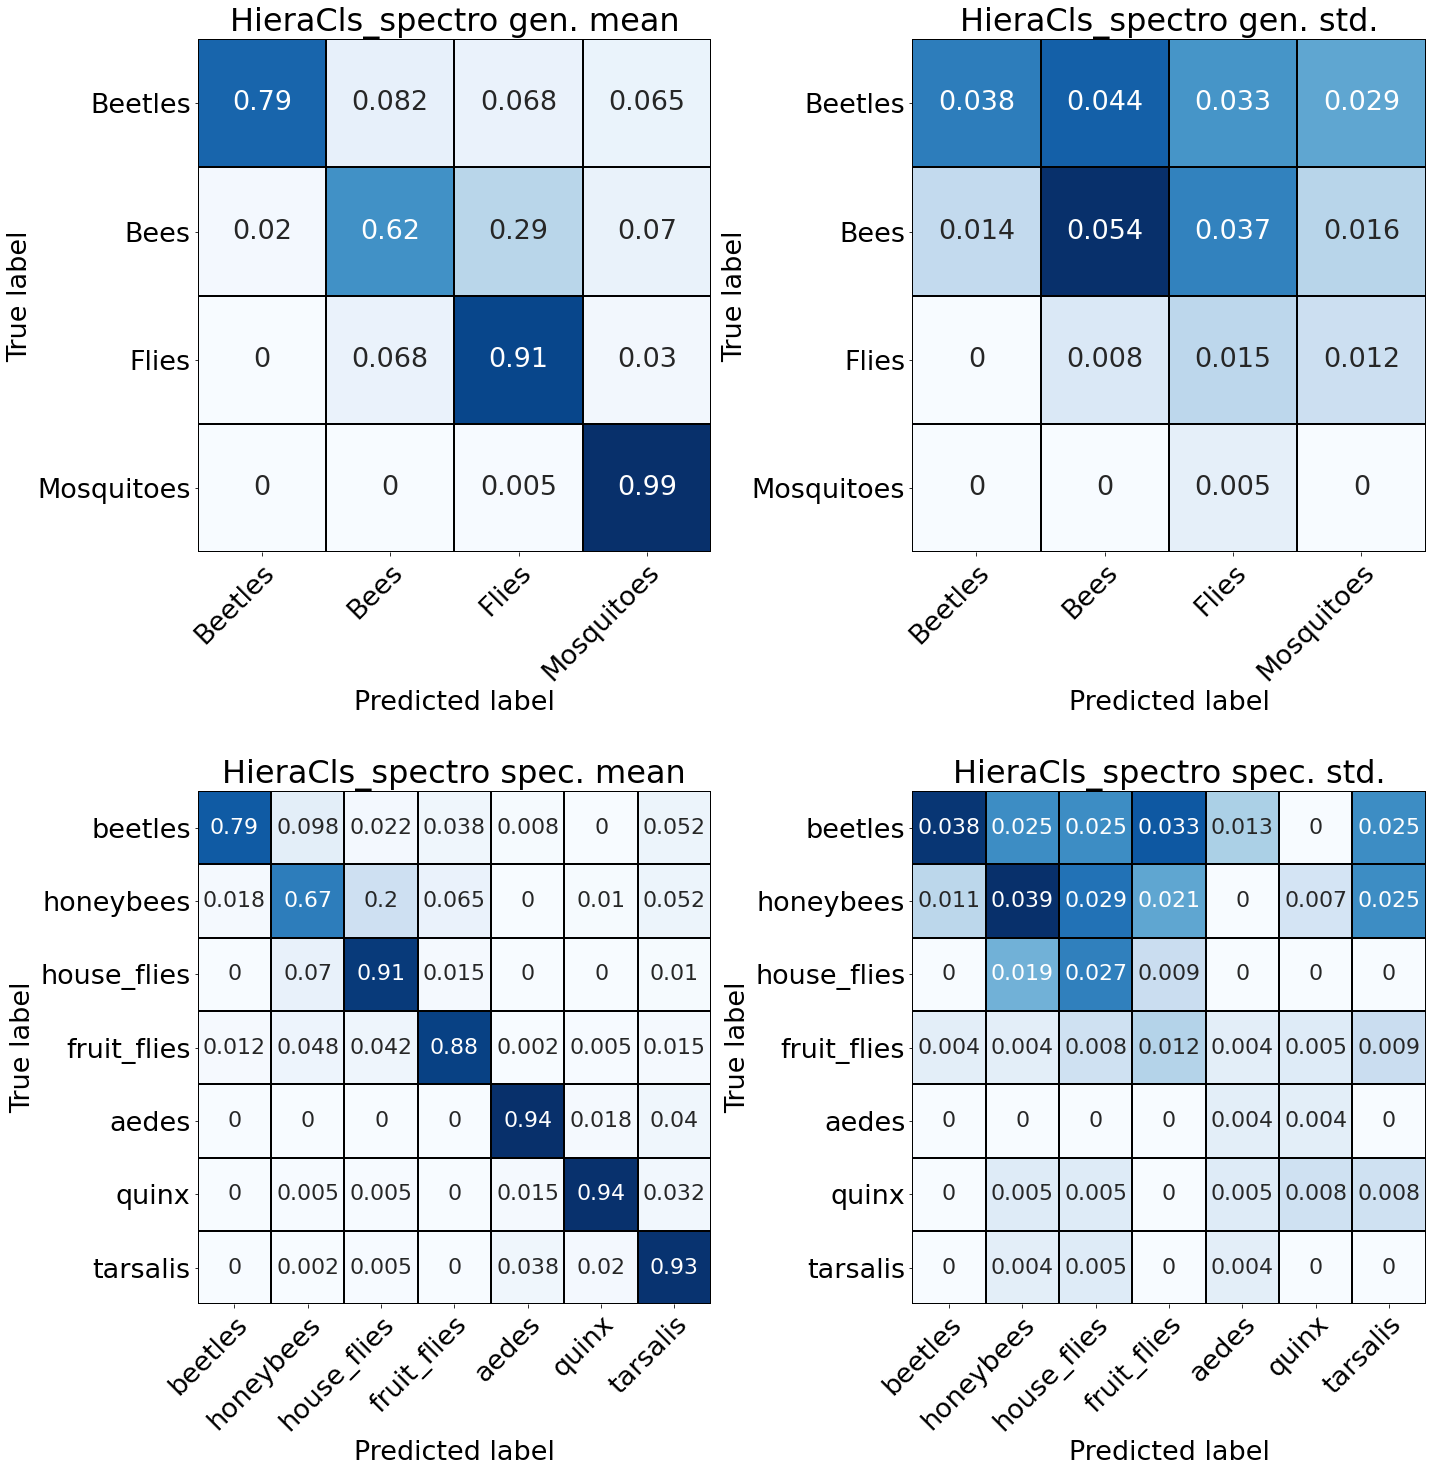

In [ ]:
# Convert confusion matrices into +/- format
#gen_mat, spec_mat = unumpy.uarray(gen_mean, gen_std), unumpy.uarray(spec_mean, spec_std)

fig = plt.figure(figsize = fig_size)
plt.subplot(221)
plot_heatmap(gen_mean, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(222)
plot_heatmap(gen_std, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(223)
plot_heatmap(spec_mean, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)

plt.subplot(224)
plot_heatmap(spec_std, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)
plt.tight_layout()
fig.savefig(model_name + '_kconf.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Compute mean statistics up to earliest training stop
stop_ep = 14
mean_loss          = np.zeros((stop_ep, ))
mean_gen_loss      = np.zeros((stop_ep, ))
mean_spec_loss     = np.zeros((stop_ep, ))
mean_gen_acc       = np.zeros((stop_ep, ))
mean_spec_acc      = np.zeros((stop_ep, ))
mean_val_loss      = np.zeros((stop_ep, ))
mean_val_gen_loss  = np.zeros((stop_ep, ))
mean_val_spec_loss = np.zeros((stop_ep, ))
mean_val_gen_acc   = np.zeros((stop_ep, ))
mean_val_spec_acc  = np.zeros((stop_ep, ))

for i in range(n_splits):
    mean_loss      += histories[i]['loss'][:stop_ep]
    mean_gen_loss  += histories[i]['genus_loss'][:stop_ep]
    mean_spec_loss += histories[i]['species_loss'][:stop_ep]
    mean_gen_acc   += histories[i]['genus_accuracy'][:stop_ep]
    mean_spec_acc  += histories[i]['species_accuracy'][:stop_ep]
    
    mean_val_loss      += histories[i]['val_loss'][:stop_ep]
    mean_val_gen_loss  += histories[i]['val_genus_loss'][:stop_ep]
    mean_val_spec_loss += histories[i]['val_species_loss'][:stop_ep]
    mean_val_gen_acc   += histories[i]['val_genus_accuracy'][:stop_ep]
    mean_val_spec_acc  += histories[i]['val_species_accuracy'][:stop_ep]
    
mean_loss      /= n_splits
mean_gen_loss  /= n_splits
mean_spec_loss /= n_splits
mean_gen_acc   /= n_splits
mean_spec_acc  /= n_splits

mean_val_loss      /= n_splits
mean_val_gen_loss  /= n_splits
mean_val_spec_loss /= n_splits
mean_val_gen_acc   /= n_splits
mean_val_spec_acc  /= n_splits

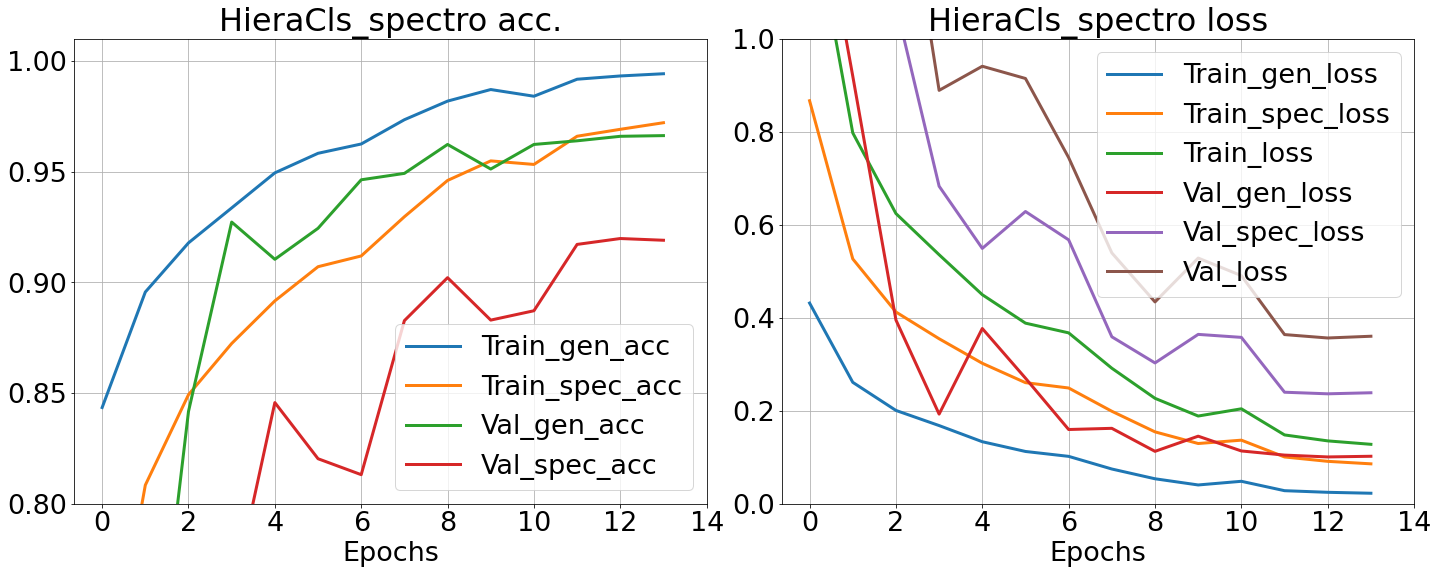

In [ ]:
fig = plt.figure(figsize = (20, 14))

plt.subplot(1, 2, 1)
plt.plot(mean_gen_acc, linewidth = 3)
plt.plot(mean_spec_acc, linewidth = 3)
plt.plot(mean_val_gen_acc, linewidth = 3)
plt.plot(mean_val_spec_acc, linewidth = 3)
plt.ylim(0.8, 1.01)
plt.xticks(np.linspace(0, stop_ep, 8), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + ' acc.', fontsize = title_size)
plt.legend(['Train_gen_acc', 'Train_spec_acc', 'Val_gen_acc', 'Val_spec_acc'], fontsize = label_size, 
           loc = 'upper left', bbox_to_anchor=(0.0, -0.25))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(mean_gen_loss, linewidth = 3)
plt.plot(mean_spec_loss, linewidth = 3)
plt.plot(mean_loss, linewidth = 3)
plt.plot(mean_val_gen_loss, linewidth = 3)
plt.plot(mean_val_spec_loss, linewidth = 3)
plt.plot(mean_val_loss, linewidth = 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.linspace(0, stop_ep, 8), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(fontsize = ticks_size)
plt.title(model_name + ' loss', fontsize = title_size)
plt.legend(['Train_gen_loss', 'Train_spec_loss', 'Train_loss', 'Val_gen_loss', 'Val_spec_loss', 'Val_loss'], 
           fontsize = label_size, loc = 'upper left', bbox_to_anchor=(0.0, -0.25))
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_kacc.eps', bbox_inches = 'tight')
plt.show()

## Hierarchical Embedder Classifier

In [ ]:
model_name = model_names[4] + '_' + input_format 
print(model_name)
out_shape = [len(species), len(genus), len(species)]
lr, reg = 5e-3, 1e-3

lr_sched = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    min_delta = 1e-2,
    min_lr = lr * 0.01, 
    patience = 3, 
    verbose = 1)

model_callbacks = [earlyStopper, lr_sched]

In [ ]:
# One model for each split in KFold
models = []
for i in range(n_splits):
    tf.keras.backend.clear_session() # avoid stacking graphs on one another
    with strategy.scope():
        cnn = CNN2D(drop_rate, name = 'CNN_Blocks'+str(i)) 
        model = build_hiera_embedder_classifier(in_shape, out_shape, cnn, reg, 
                                                input_name = input_format, model_name = model_name)
        model.compile(tf.keras.optimizers.Adam(lr), 
                      loss = {
                          "embedding": embedding_loss(emb_matrix),
                          "genus":   'sparse_categorical_crossentropy', 
                          "species": 'sparse_categorical_crossentropy',
                      },
                      loss_weights = {"embedding": 1.0, "genus": 1.0, "species": 1.0},
                      metrics = {"embedding": embedding_similarity(emb_matrix),
                                 "genus": 'accuracy', "species": 'accuracy'})
    models.append(model)

In [ ]:
gen_mean, gen_std, spec_mean, spec_std, histories = kfold_cv(X_train, y_train, models, genus_mapping, emb_matrix, 
                                                             n_splits, epochs, batch_size, sm, model_callbacks, 
                                                             sampling_rate, window, nperseg, noverlap, cutoff)

In [ ]:
# Convert confusion matrices into +/- format
#gen_mat, spec_mat = unumpy.uarray(gen_mean, gen_std), unumpy.uarray(spec_mean, spec_std)

fig = plt.figure(figsize = fig_size)
plt.subplot(221)
plot_heatmap(gen_mean, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(222)
plot_heatmap(gen_std, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' gen. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(223)
plot_heatmap(spec_mean, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. mean',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)

plt.subplot(224)
plot_heatmap(spec_std, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + ' spec. std.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size-5)
plt.tight_layout()
fig.savefig(model_name + '_kconf.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Compute mean statistics up to earliest training stop
stop_ep = 18
mean_loss          = np.zeros((stop_ep, ))
mean_emb_loss      = np.zeros((stop_ep, ))
mean_gen_loss      = np.zeros((stop_ep, ))
mean_spec_loss     = np.zeros((stop_ep, ))
mean_emb_sim       = np.zeros((stop_ep, ))
mean_gen_acc       = np.zeros((stop_ep, ))
mean_spec_acc      = np.zeros((stop_ep, ))
mean_val_loss      = np.zeros((stop_ep, ))
mean_val_emb_loss  = np.zeros((stop_ep, ))
mean_val_gen_loss  = np.zeros((stop_ep, ))
mean_val_spec_loss = np.zeros((stop_ep, ))
mean_val_emb_sim   = np.zeros((stop_ep, ))
mean_val_gen_acc   = np.zeros((stop_ep, ))
mean_val_spec_acc  = np.zeros((stop_ep, ))

for i in range(n_splits):
    # Training
    mean_loss      += histories[i]['loss'][:stop_ep]
    mean_emb_loss  += histories[i]['embedding_loss'][:stop_ep]
    mean_gen_loss  += histories[i]['genus_loss'][:stop_ep]
    mean_spec_loss += histories[i]['species_loss'][:stop_ep]
    mean_emb_sim   += histories[i]['embedding_similarity'][:stop_ep]
    mean_gen_acc   += histories[i]['genus_accuracy'][:stop_ep]
    mean_spec_acc  += histories[i]['species_accuracy'][:stop_ep]
    
    # Validation
    mean_val_loss      += histories[i]['val_loss'][:stop_ep]
    mean_val_emb_loss  += histories[i]['val_embedding_loss'][:stop_ep]
    mean_val_gen_loss  += histories[i]['val_genus_loss'][:stop_ep]
    mean_val_spec_loss += histories[i]['val_species_loss'][:stop_ep]
    mean_val_emb_sim   += histories[i]['val_embedding_similarity'][:stop_ep]
    mean_val_gen_acc   += histories[i]['val_genus_accuracy'][:stop_ep]
    mean_val_spec_acc  += histories[i]['val_species_accuracy'][:stop_ep]
    
mean_loss      /= n_splits
mean_emb_loss  /= n_splits
mean_gen_loss  /= n_splits
mean_spec_loss /= n_splits
mean_emb_sim   /= n_splits
mean_gen_acc   /= n_splits
mean_spec_acc  /= n_splits

mean_val_loss      /= n_splits
mean_val_emb_loss  /= n_splits
mean_val_gen_loss  /= n_splits
mean_val_spec_loss /= n_splits
mean_val_emb_sim   /= n_splits
mean_val_gen_acc   /= n_splits
mean_val_spec_acc  /= n_splits

In [ ]:
fig = plt.figure(figsize = (20, 14))

plt.subplot(1, 2, 1)
plt.plot(mean_emb_sim, linewidth = 3)
plt.plot(mean_gen_acc, linewidth = 3)
plt.plot(mean_spec_acc, linewidth = 3)
plt.plot(mean_val_emb_sim, linewidth = 3)
plt.plot(mean_val_gen_acc, linewidth = 3)
plt.plot(mean_val_spec_acc, linewidth = 3)
plt.ylim(0.8, 1.01)
plt.xticks(np.linspace(0, stop_ep, 10), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + ' acc. and sim.', fontsize = title_size)
plt.legend(['Train_sim', 'Train_gen_acc', 'Train_spec_acc', 'Val_sim', 'Val_gen_acc', 'Val_spec_acc'], 
           fontsize = label_size, loc = 'upper left', bbox_to_anchor=(0.0, -0.25))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(mean_emb_loss, linewidth = 3)
plt.plot(mean_gen_loss, linewidth = 3)
plt.plot(mean_spec_loss, linewidth = 3)
plt.plot(mean_loss, linewidth = 3)
plt.plot(mean_val_emb_loss, linewidth = 3)
plt.plot(mean_val_gen_loss, linewidth = 3)
plt.plot(mean_val_spec_loss, linewidth = 3)
plt.plot(mean_val_loss, linewidth = 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.linspace(0, stop_ep, 10), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(fontsize = ticks_size)
plt.title(model_name + ' loss', fontsize = title_size)
plt.legend(['Train_emb_loss', 'Train_gen_loss', 'Train_spec_loss', 'Train_loss', 
            'Val_emb_loss',   'Val_gen_loss',   'Val_spec_loss',   'Val_loss'], 
           fontsize = label_size, loc = 'upper left', bbox_to_anchor=(0.0, -0.25))
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_kacc.eps', bbox_inches = 'tight')
plt.show()